<a href="https://colab.research.google.com/github/felixzhao/HARDataset/blob/main/Halter_V1_HAR_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib as mpl

In [3]:
import tensorflow as tf

In [4]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# Utilities

In [5]:
"""
A python class which load Interial Signals data from HAR data set
"""
class HARDataSetLoader:
    def __init__(self, root_path):
        self.root = root_path
        self.file_dir = '/Inertial Signals/'
        self.file_prefix = ['total_acc_', 'body_acc_', 'body_gyro_']
        self.feature_type = ['x_', 'y_', 'z_']
        self.file_type = '.txt'
        self.num_classes = None

    def _get_feature_files_full_path(self, file_type:str):
        feature_files = []
        for prefix in self.file_prefix:
            for f_type in self.feature_type:
                full_path = f"{self.root}{file_type}{self.file_dir}" \
                            + f"{prefix}{f_type}{file_type}{self.file_type}"
                feature_files.append(full_path)
        return feature_files

    def _get_label_file_full_path(self, file_type:str):
        return f'{self.root}{file_type}/y_{file_type}.txt'

    def __load_file(self, file_path:str):
        return pd.read_csv(file_path, header=None, delim_whitespace=True).values

    def _load_feature(self, feature_files):
        features = np.dstack(
            [
                self.__load_file(f) for f in feature_files
            ]
        )
        return features

    def _load_label(self, label_file):
        """
        load label y from file,
        decrease 1 label number, as tensorflow categorical start from 0.
        then generate keras categorical of labels as output 
        """
        labels = self.__load_file(label_file)
        self.num_classes = len(np.unique(labels))
        labels = labels - 1
        return tf.keras.utils.to_categorical(labels)

    def _load(self, split_type:str):
        feature_file_names = self._get_feature_files_full_path(split_type)
        label_file_name = self._get_label_file_full_path(split_type)
        print(feature_file_names)
        print(label_file_name)
        X = self._load_feature(feature_file_names)
        y = self._load_label(label_file_name)
        print(X.shape, y.shape)
        return X, y

    def load_train(self):
        print('load train data.')
        return self._load('train')

    def load_test(self):
        print('load test data.')
        return self._load('test')
  

# load data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
root_path = "drive/MyDrive/UCI_HAR_Dataset/"
loader = HARDataSetLoader(root_path=root_path)
X_train, y_train = loader.load_train()
X_test, y_test = loader.load_test()
print(f'{loader.num_classes=}')

load train data.
['drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_z_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_z_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_z_train.txt']
drive/MyDrive/UCI_HAR_Dataset/train/y_train.txt
(7352, 128, 9) (7352, 6)
load test data.
['drive/MyDrive/UCI_HAR_Dataset/test/Inertial Signals/total_acc_x_test.txt', 'drive/MyDrive/UCI_HAR_Dataset/test/Inertial Signals/total_acc_y_test.txt', 'drive/MyDrive/UCI_HAR_Dataset/test/Inert

# Train model

In [8]:
train_shape = X_train.shape
batch_size = train_shape[0]
sequence_length = train_shape[1]
number_of_features = train_shape[2]
num_classes = loader.num_classes
print(f"{batch_size=}, {sequence_length=}, {number_of_features=}, {num_classes=} ")

batch_size=7352, sequence_length=128, number_of_features=9, num_classes=6 


In [9]:
learning_rate = 0.01
n_hidden = 32
batch_size = 64
shuffle_buffer_size = 1000
epochs = 30

## Train LSTM model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, input_shape=(sequence_length, number_of_features)),
#   tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

#Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test) ,epochs=epochs)

Epoch 1/30
230/230 [==============================] - 7s 31ms/step - loss: 0.1370 - accuracy: 0.9448 - val_loss: 0.4209 - val_accuracy: 0.8914
Epoch 2/30
230/230 [==============================] - 7s 32ms/step - loss: 0.1148 - accuracy: 0.9513 - val_loss: 0.3753 - val_accuracy: 0.8962
Epoch 3/30
230/230 [==============================] - 8s 35ms/step - loss: 0.1145 - accuracy: 0.9521 - val_loss: 0.3842 - val_accuracy: 0.8884
Epoch 4/30
230/230 [==============================] - 8s 34ms/step - loss: 0.1298 - accuracy: 0.9453 - val_loss: 0.3909 - val_accuracy: 0.8941
Epoch 5/30
230/230 [==============================] - 8s 35ms/step - loss: 0.1103 - accuracy: 0.9528 - val_loss: 0.3608 - val_accuracy: 0.9006
Epoch 6/30
230/230 [==============================] - 8s 37ms/step - loss: 0.1049 - accuracy: 0.9535 - val_loss: 0.4325 - val_accuracy: 0.8867
Epoch 7/30
230/230 [==============================] - 7s 32ms/step - loss: 0.1005 - accuracy: 0.9558 - val_loss: 0.4531 - val_accuracy: 0.9036

## evaluate model

The LSTM accuracy from train set is 0.94, but from test set only 0.89.
There are 5% difference between accuracy of train and test.
It is clearly overfitting.


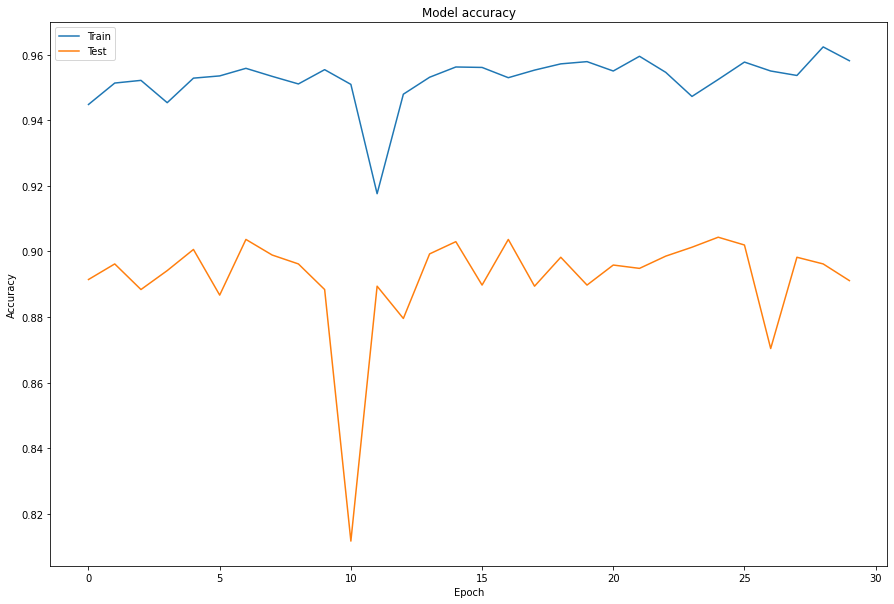

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Train CNN + LSTM model

In this section, we will try a more complex model and use some regularization methods to prevent overfitting on it.

Regularization is a technique used to prevent overfitting in deep neural networks (DNNs). Some common regularization methods include:

- L1 regularization: Also known as Lasso regularization, this method adds a penalty term to the loss function that is proportional to the absolute value of the weights. This results in some weights being set to zero, effectively removing those features from the model.

- L2 regularization: Also known as Ridge regularization, this method adds a penalty term to the loss function that is proportional to the square of the weights. This results in small, non-zero weights, which can help prevent overfitting.

- Dropout: This is a form of regularization that randomly drops out neurons during training, forcing the remaining neurons to learn more robust features.

- Early stopping: This method stops training the model before it reaches convergence, in order to prevent overfitting.

- Data augmentation: This method artificially increases the size of the training dataset by applying random transformations to the existing data, such as flipping images or adding noise. This can help the model generalize better.

- Batch normalization: This method normalizes the activations of the neurons in a batch, which helps to speed up training and reduce the effects of internal covariate shift.

- Max norm regularization: This method constrains the weights of the network such that the maximum L2 norm of the weights of a layer is less than a fixed value.

- Weight decay: This method is similar to L2 regularization, but instead of adding the penalty term to the loss function, it modifies the learning rate so that the optimizer takes smaller steps when the gradients are high.

As we known, in this problem the data is not sparse data. Thus, L2 may the better way than L1, as L1 could removing features. And we will try Dropout and early stopping as well.

Here we use an CNN + LSTM solution.

Convolutional neural networks (CNNs) are commonly used in image and video processing tasks, but they can also be applied to time series data. In particular, a 1D convolutional layer (Conv1D) can be used to extract features from a time series by sliding a kernel (a small matrix of weights) along the sequence, performing a dot product at each position, and applying a non-linear activation function. This allows the model to learn local patterns in the data, such as trends or periodicity, that may be useful for classification. Additionally, Conv1D can also be used in combination with pooling layers to reduce the dimensionality of the data and make the model more robust to noise.

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that can be used for time series classification tasks. Unlike traditional RNNs, LSTMs have a memory cell that can store information from previous time steps, allowing them to better handle long-term dependencies in the data. This is especially useful for time series data, where patterns may be spread out over a long period of time and traditional RNNs may struggle to capture these dependencies. Additionally, LSTMs have gates (input, output and forget gates) that can selectively choose which information to keep, discard or update in the memory, which helps to prevent the vanishing and exploding gradient problem commonly faced by RNNs. LSTM can learn to recognize patterns, trends and anomalies in sequential data, which is useful in time series classification tasks.

Softmax is a common choice for the final activation function in a neural network when the task is multi-class classification. The function maps the output of the network to a probability distribution over the different classes, allowing the model to make predictions about the most likely class for a given input.






In [53]:
"""
padding='causal', 
    the input tensor is only padded on the left side, 
    and the output at time t only depends on past observations 
    and not on future observations. 
    This is useful in time series analysis.

strides=1, 
    the filter moves one step at a time along the width dimension, 
    and the output will have the same width as the input. 
    This means that the filter will be applied to every element of the input tensor, 
    resulting in the most detailed representation of the input. 

kernel_regularizer=tf.keras.regularizers.l2(0.001),
    the L2 regularizer is being used with a regularization rate of 0.001. 
    This means that for every weight in the weight matrix, 
    the square of its value will be multiplied by 0.001 
    and added to the overall loss during training, 
    encouraging the weights to be small and reducing overfitting.
"""
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(
      filters=32, 
      kernel_size=4,
      strides=1,
      activation="relu",
      padding='causal',
      input_shape=(sequence_length, number_of_features),
      kernel_regularizer=tf.keras.regularizers.l2(0.001),
      ),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

#Print the model summary 
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 128, 32)           1184      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 6)                 390       
                                                                 
Total params: 12,006
Trainable params: 12,006
Non-trainable params: 0
_________________________________________________________________


In [54]:
# early_stop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
early_stop_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-8, verbose=1)


# Train the model
history = model.fit(X_train, y_train ,validation_data=(X_test, y_test) ,epochs=50, callbacks=[early_stop_acc, reduce_lr])

Epoch 1/50
230/230 [==============================] - 11s 39ms/step - loss: 0.8454 - accuracy: 0.6133 - val_loss: 0.6273 - val_accuracy: 0.7211 - lr: 0.0100
Epoch 2/50
230/230 [==============================] - 9s 37ms/step - loss: 0.5256 - accuracy: 0.7734 - val_loss: 0.5194 - val_accuracy: 0.8310 - lr: 0.0100
Epoch 3/50
230/230 [==============================] - 9s 38ms/step - loss: 0.3852 - accuracy: 0.8702 - val_loss: 0.7166 - val_accuracy: 0.7391 - lr: 0.0100
Epoch 4/50
230/230 [==============================] - 10s 42ms/step - loss: 0.3364 - accuracy: 0.8961 - val_loss: 0.6705 - val_accuracy: 0.8493 - lr: 0.0100
Epoch 5/50
230/230 [==============================] - 9s 37ms/step - loss: 0.3680 - accuracy: 0.9026 - val_loss: 0.5444 - val_accuracy: 0.8748 - lr: 0.0100
Epoch 6/50
230/230 [==============================] - 9s 38ms/step - loss: 0.2737 - accuracy: 0.9289 - val_loss: 0.4759 - val_accuracy: 0.8904 - lr: 0.0100
Epoch 7/50
230/230 [==============================] - 9s 38ms/

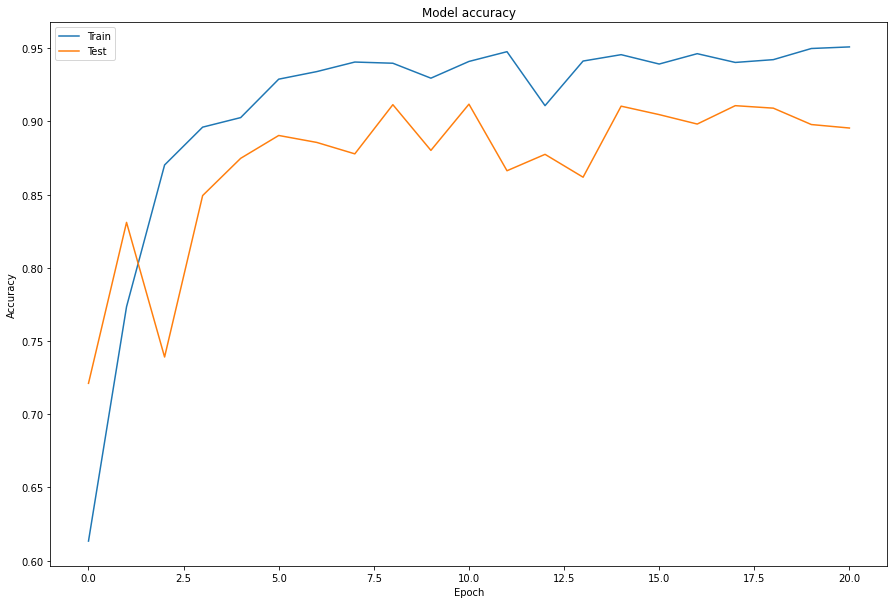

In [55]:
fig = plt.figure(figsize=(15, 10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# GridSearchCV

We can use Grid Search CV to tuning the parameters of model. for example, tunning the regulariztion rate or dropout rate.


It takes too long to run thus here is the sample code, 

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime

In [ ]:
def create_model(l2_rate=0.0):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                          strides=1,
                          activation="relu",
                          padding='causal',
                          input_shape=(sequence_length, number_of_features)),
      tf.keras.layers.LSTM(32),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_rate)),
      tf.keras.layers.Dense(number_of_classes, activation="softmax")
    ])
    model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )
    return model

# create the model
model_cv = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

<ipython-input-59-86912c2ff979>:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)


In [ ]:
# define the grid search parameters
l2_rate = [0.0, 0.001, 0.01, 0.1]
param_grid = dict(l2_rate=l2_rate)
grid = GridSearchCV(estimator=model_cv, param_grid=param_grid, cv=3)

In [ ]:
start_time = datetime.now()

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(f'time cost: {datetime.now()-start_time}')

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Experiment Result

## confusion matrix

In the work CNN + LSTM, test accuracy reach to 91.2%.

Based on the Confusion matrix most of the classes are correct.

Except "Standing" and "sitting", which we can do more analysis in future work.

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

93/93 - 1s - loss: 0.3749 - accuracy: 0.9118 - 707ms/epoch - 8ms/step
Test accuracy: 0.9117746949195862


In [57]:
y_pred = model.predict(X_test)

93/93 [==============================] - 1s 9ms/step


In [58]:
y_pred_res = tf.argmax(y_pred, axis=1)
y_test_res = tf.argmax(y_test, axis=1)

In [59]:
cm = tf.math.confusion_matrix(y_test_res, y_pred_res, num_classes=num_classes)

In [60]:
class_names = [ 'WALKING',
    'WALKING_UPSTAIRS',
     'WALKING_DOWNSTAIRS',
     'SITTING',
     'STANDING',
     'LAYING',
]

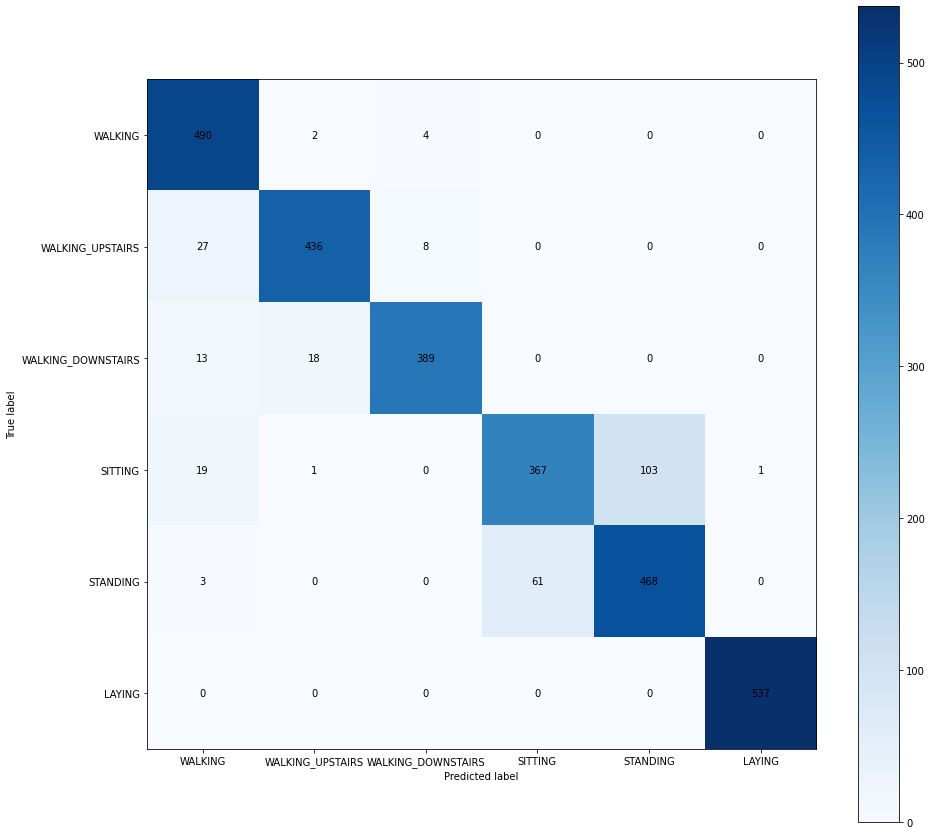

In [61]:
cm = np.array(cm)

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Conculsion

In this work, we found simple LSTM not works well and lead to overfitting.

We introduce an approach CNN + LSTM with regularzation.

The CNN layer allows the model to learn local patterns in the data, such as trends or periodicity, that may be useful for classification. 

And LSTMs memory information from previous time steps, allowing them to better handle long-term dependencies in the data. And it has abality to prevent the vanishing and exploding gradient problem.


in further work, we can combine Conv1D with pooling layers to reduce the dimensionality of the data and make the model more robust to noise.

### CNN

Pros
- They are able to learn features from the input data automatically, without the need for manual feature engineering.

Cons
- CNNs require a large amount of data and computational resources to train.
- They are sensitive to the quality and annotation of the training data, which can lead to overfitting if the data is not diverse or representative enough.
- They can be difficult to interpret, as the learned features are often abstract and not directly related to the input data.

### LSTM for time series classification
Pros

- LSTMs are well suited for time series classification tasks as they are able to effectively capture long-term dependencies in sequential data.
- LSTMs are able to handle input sequences of varying lengths, which is useful for handling variable-length time series data.
- LSTMs are able to learn the underlying patterns and trends in the time series data, which can be useful for making accurate predictions.


Cons

- LSTMs can be computationally expensive to train and run, particularly when dealing with large input sequences or large amounts of data.
- LSTMs can be difficult to interpret and understand, as they are a complex model with many internal components.
- LSTMs can be prone to overfitting if not properly regularized, as they have a large number of parameters that can be adjusted.
- LSTMs may not be suitable for time series data with high frequency, as the model might not be able to capture the high-frequency patterns.
- LSTMs may not be suitable for time series data with a high degree of noise, as the model might not be able to differentiate between noise and signal.